In [ ]:
# импорт необходимых библиотек

import pandas as pd
import tensorflow as tf
import tensorflow.keras
import keras

from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential, load_model, model_from_json
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, AveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


import cv2
import numpy as np
from imutils import paths
import os
import json
import scipy.misc

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
version = "FER_V1_"
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
bs = 200 #Размер минивыборки
epochs_vgg = 56 #количество эпох для модели
patience = 15
optimizer = keras.optimizers.Adam() # оптимизатор (Adam,Nadam,Adamax, Adadelta)

ds1_path = "/content/drive/My Drive/FER_DATA/fer2013.csv" #путь к 1 набору данных (FER_2013)
ds2_path = "/content/drive/My Drive/FER_DATA/emotion_compilation.zip" #путь к 2 набору данных

model_vgg_path = "/content/drive/My Drive/FER_MODEL/model_vgg_"
model_vgg_plus_path = "/content/drive/My Drive/FER_MODEL/model_vgg_plus_"
model_vgg_tuner_path = "/content/drive/My Drive/FER_MODEL/model_vgg_tuner_"

#TRUE чтобы обучить     FALSE чтобы взять готовые веса
fit_vgg = True   
fit_vgg_plus = False
fit_vgg_tuner = False

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/FER_DATA/fer2013.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/FER_DATA/')


In [ ]:
#cpu - gpu config
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1, 'CPU': 4})
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
df_fer = pd.read_csv(ds1_path)
df_ec = ds2_path

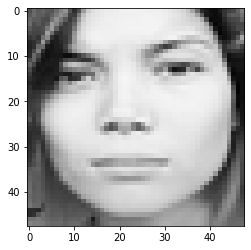

In [ ]:
import matplotlib.pyplot as plt
face = np.array(df_fer['pixels'])[35]
face = np.array([el for el in face.split(' ')]).astype(np.float32) 
face = face.reshape(48, 48)
plt.imshow(face, cmap='gray', vmin=0, vmax=255)

In [ ]:
f = open (ds1_path)
content = f.readlines()
lines = np.array(content)


In [ ]:
df_fer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
df_fer.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
# вывод количества записей
num_of_instances = lines.size
print("В наборе FER_2013.csv:", num_of_instances, " записей", df_fer.shape)

В наборе FER_2013.csv: 35888  записей (35887, 3)


In [ ]:
df_fer.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
# Поиск и удаление дубликатов
df_fer = df_fer.drop_duplicates()
df_fer = df_fer.dropna()
df_fer.shape

(34653, 3)

In [ ]:
# Поиск пропусков
print("Процент отсутствующих данных в наборе FER_2013")
for col in df_fer.columns:
    pct_missing = np.mean(df_fer[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Процент отсутствующих данных в наборе FER_2013
emotion - 0%
pixels - 0%
Usage - 0%


In [ ]:
#Количество пикселей в изображении 48х48=2304
print("instance length:  ", len(lines[1].split(",")[1].split(" ")))

instance length:   2304


In [ ]:
print(num_of_instances)

35888


In [ ]:
# Разделение исходного набора данных на 3 выборки
x_train, y_train, x_test, y_test, x_val, y_val = [], [], [], [], [], []
for i in range(1,num_of_instances):
  emotion, img, usage = lines[i].split(",")
  val = img.split(" ")
  pixels = np.array(val, 'float32')
  emotion = to_categorical(emotion, num_classes)
        
  if 'Training' in usage:
      y_train.append(emotion)
      x_train.append(pixels)
  elif 'PublicTest' in usage:
      y_test.append(emotion)
      x_test.append(pixels)
  elif 'PrivateTest' in usage:
      y_val.append(emotion)
      x_val.append(pixels)


In [ ]:
#Заполнение массивов
#Нормализация данных о интенсивности пикселов изображения
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')
x_val = np.array(x_val, 'float32')
y_val = np.array(y_val, 'float32')

x_train /=255  #normalize inputs between [0,1]
x_test /=255
x_val /=255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')
x_val = x_val.reshape(x_test.shape[0], 48, 48, 1)
x_val = x_val.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

28709 train samples
3589 test samples
3589 validation samples


In [ ]:
y_test.shape

(3589, 7)

In [ ]:
def VGG_Model(input_shape=(48,48,1)):
    
    
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)

    pool1_1 = MaxPool2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    
    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(pool1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)

    pool2_1 = MaxPool2D(pool_size=(2,2), name = 'pool2_1')(conv2_2)
    
    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(pool2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)

    pool3_1 = MaxPool2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    
    #the 4-th block
    conv4_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(pool3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)

    pool4_1 = MaxPool2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(pool4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_4 = BatchNormalization()(conv5_3)

    pool5_1 = MaxPool2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    
    #Flatten 
    flatten = Flatten(name = 'flatten')(pool5_1)
    # Fullconnection layers
    fc1 = Dense(4096,activation='relu', name='fc1')(flatten)
    fc2 = Dense(4096,activation='relu', name='fc2')(fc1)
    fc3 = Dense(1000,activation='relu', name='fc3')(fc2)
    # Output layer
    ouput = Dense(num_classes, activation='softmax', name = 'output')(fc3)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [ ]:
model_vgg = VGG_Model()
model_vgg.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 24, 24, 128)       73856 

In [ ]:
if fit_vgg == True:
    hist_1 = model_vgg.fit(x_train, y_train, epochs = epochs_vgg, batch_size=bs, validation_data=(x_val, y_val), verbose = 1, shuffle=False)
else:
    hist_1 = model_vgg.load_weights(model_vgg_path + version + str(epochs_vgg) + "_weights.h5")

Epoch 1/56
144/144 [==============================] - 86s 245ms/step - loss: 3.0213 - accuracy: 0.2449 - val_loss: 1.8451 - val_accuracy: 0.2524
Epoch 2/56
144/144 [==============================] - 31s 214ms/step - loss: 1.4966 - accuracy: 0.4090 - val_loss: 2.0997 - val_accuracy: 0.2079
Epoch 3/56
144/144 [==============================] - 31s 219ms/step - loss: 1.3259 - accuracy: 0.4850 - val_loss: 1.9373 - val_accuracy: 0.2836
Epoch 4/56
144/144 [==============================] - 31s 216ms/step - loss: 1.2162 - accuracy: 0.5322 - val_loss: 1.4836 - val_accuracy: 0.4745
Epoch 5/56
144/144 [==============================] - 31s 217ms/step - loss: 1.1401 - accuracy: 0.5656 - val_loss: 1.2506 - val_accuracy: 0.5355
Epoch 6/56
144/144 [==============================] - 31s 217ms/step - loss: 1.0585 - accuracy: 0.5997 - val_loss: 1.4443 - val_accuracy: 0.4960
Epoch 7/56
144/144 [==============================] - 31s 217ms/step - loss: 0.9863 - accuracy: 0.6317 - val_loss: 1.4203 - val_ac

In [ ]:
# Saving  the model
model_vgg_json = model_vgg.to_json()
with open(model_vgg_path +  version + str(epochs_vgg) +".json", "w") as json_file:
    json.dump(model_vgg_json, json_file)

model_vgg.save_weights(model_vgg_path +  version + str(epochs_vgg) + "_weights.h5")

In [ ]:
# visualizing losses and accuracy
#loss_and_acc()
def visual_acc(hist):
  train_acc  = hist.history['accuracy']
  val_acc    = hist.history['val_accuracy']
  #plt.figure(figsize=(15,7))
  plt.plot(hist.history['accuracy'], label='Доля верных ответов на обучющем наборе')
  plt.plot(hist.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train-Val accuracy')

In [ ]:
def visual_loss(hist):
  train_loss = hist.history['loss']
  val_loss   = hist.history['val_loss']
  #plt.figure(figsize=(15,7))
  plt.plot(hist.history['loss'], label='Доля промахов на обучющем наборе')
  plt.plot(hist.history['val_loss'], label='Доля промахов на проверочном наборе')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Train-Val Loss')

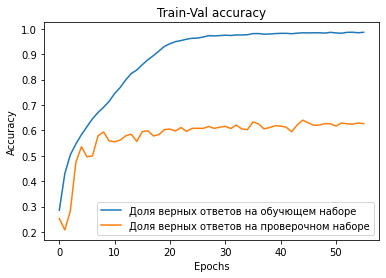

In [ ]:
if fit_vgg == True:
  visual_acc(hist_1)

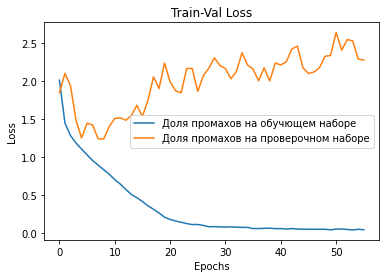

In [ ]:
if fit_vgg == True:
  visual_loss(hist_1)

In [ ]:
if fit_vgg == True:
  y_pred_keras = model_vgg.predict(x_test)

  model_vgg.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy']             )


  score = model_vgg.evaluate(x_train, y_train)
  print('Train loss: ', score[0])
  print("Train accuracy: %.2f%%" % (100*score[1]))

  score = model_vgg.evaluate(x_val, y_val)
  print('Validation loss: ', score[0])
  print("Validation accuracy: %.2f%%" % (100*score[1]))
  print(model_vgg.metrics_names)

  score = model_vgg.evaluate(x_test, y_test)
  print('Test loss: ', score[0])
  print("Test accuracy: %.2f%%" % (100*score[1]))
  print(model_vgg.metrics_names)

898/898 [==============================] - 16s 16ms/step - loss: 0.1205 - accuracy: 0.9662
Train loss:  0.10276616364717484
Train accuracy: 97.11%
113/113 [==============================] - 2s 16ms/step - loss: 2.2756 - accuracy: 0.6266
Validation loss:  2.2756080627441406
Validation accuracy: 62.66%
['loss', 'accuracy']
113/113 [==============================] - 2s 16ms/step - loss: 2.3113 - accuracy: 0.6239
Test loss:  2.311284065246582
Test accuracy: 62.39%
['loss', 'accuracy']


In [ ]:
# Сохранение весов в процессе обучения
from keras.callbacks import ModelCheckpoint
weights_file_vgg_plus = model_vgg_plus_path + version + str(epochs_vgg)
checkpoint_vgg = ModelCheckpoint(weights_file_vgg_plus, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
# Калбэк ранней остановки обучения
early_stopping_callback_vgg = EarlyStopping(monitor='val_accuracy', patience = patience)

In [ ]:
def VGG_Model_plus(input_shape=(48,48,1)):
    
    
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7

    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)

    pool1_1 = MaxPool2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)
    
    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)

    pool2_1 = MaxPool2D(pool_size=(2,2), name = 'pool2_1')(conv2_2)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)
    
    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)

    pool3_1 = MaxPool2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)
    
    #the 4-th block
    conv4_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)

    pool4_1 = MaxPool2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_4 = BatchNormalization()(conv5_3)

    pool5_1 = MaxPool2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)
    
    #Flatten 
    flatten = Flatten(name = 'flatten')(drop5_1)
    # Fullconnection layers
    fc1 = Dense(4096,activation='relu', name='fc1')(flatten)
    drop6_1 = Dropout(0.3, name = 'drop6_1')(fc1)
    fc2 = Dense(4096,activation='relu', name='fc2')(drop6_1)
    drop6_2 = Dropout(0.3, name = 'drop6_2')(fc2)
    fc3 = Dense(1000,activation='relu', name='fc3')(drop6_2)
    # Output layer
    ouput = Dense(num_classes, activation='softmax', name = 'output')(fc3)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [ ]:
model_vgg_plus = VGG_Model_plus()
model_vgg_plus.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
drop1_1 (Dropout)            (None, 24, 24, 64)        0   

In [ ]:
# adding shuffle and callbacks
#callbacks = [early_stopping_callback_vgg, checkpoint_vgg]
if fit_vgg_plus == True:
    hist_2 = model_vgg_plus.fit(x_train, y_train, epochs = epochs_vgg, validation_data=(x_val, y_val), batch_size=bs, verbose = 1, shuffle=True, callbacks=[early_stopping_callback_vgg,checkpoint_vgg])
else:
    hist_2 = model_vgg_plus.load_weights(model_vgg_plus_path + version + str(epochs_vgg) + "_weights.h5")

OSError: ignored

In [ ]:
if fit_vgg_plus == True:
  visual_acc(hist_2)

In [ ]:
if fit_vgg_plus == True:
  visual_loss(hist_2)

In [ ]:
if fit_vgg_plus == True:
  y_pred_keras = model_vgg_plus.predict(x_test)

  model_vgg_plus.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy']             )


  score = model_vgg_plus.evaluate(x_train, y_train)
  print('Train loss: ', score[0])
  print("Train accuracy: %.2f%%" % (100*score[1]))

  score = model_vgg_plus.evaluate(x_val, y_val)
  print('Validation loss: ', score[0])
  print("Validation accuracy: %.2f%%" % (100*score[1]))
  print(model_vgg_plus.metrics_names)

  score = model_vgg_plus.evaluate(x_test, y_test)
  print('Test loss: ', score[0])
  print("Test accuracy: %.2f%%" % (100*score[1]))
  print(model_vgg_plus.metrics_names)

In [ ]:
!git clone https://github.com/keras-team/keras-tuner.git

In [ ]:
%cd keras-tuner
!pip install .

In [ ]:
from kerastuner import Hyperband

In [ ]:
# Функция построения модели VGG с тюнером
def build_VGG_tuner(hp):
  activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'linear'])
  hidden_layers_choice = hp.Choice('hidden_layers', values=[2, 3, 4, 5, 6, 7, 8])
  #optimizer_choice = hp.Choice('optimizer', values=['adam', 'Adagrad, SGD'])
  kernel_choice = hp.Choice('kernel_size', values=[3, 5, 7])
  dropout_choice = hp.Choice('rate', values=[0.1, 0.2, 0.3, 0.4])
  num_classes = 7
  

  model = Sequential()
  # first input model
  #model.add(Input(shape=(48,48,1)))
  
  #the 1-st block
  model.add(Conv2D(64, kernel_size=kernel_choice, input_shape = (48,48,1), activation='relu', padding='same', name = 'conv1_1'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv1_2'))
  model.add(BatchNormalization())

  model.add(MaxPool2D(pool_size=(2,2), name = 'pool1_1'))
  model.add(Dropout(dropout_choice, name = 'drop1_1'))

  #the 2-nd block
  model.add(Conv2D(128, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv2_1'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv2_2'))
  model.add(BatchNormalization())

  model.add(MaxPool2D(pool_size=(2,2), name = 'pool2_1'))
  model.add(Dropout(dropout_choice, name = 'drop2_1'))

  #the 3-rd block
  model.add(Conv2D(256, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv3_1'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv3_2'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv3_3'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv3_4'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2), name = 'pool3_1'))
  model.add(Dropout(dropout_choice, name = 'drop3_1'))

  #the 4-th block
  model.add(Conv2D(512, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv4_1'))
  model.add(BatchNormalization())
  model.add(Conv2D(512, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv4_2'))
  model.add(BatchNormalization())
  model.add(Conv2D(512, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv4_3'))
  model.add( BatchNormalization())
  model.add( Conv2D(512, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv4_4'))
  model.add( BatchNormalization())

  model.add( MaxPool2D(pool_size=(2,2), name = 'pool4_1'))
  model.add( Dropout(dropout_choice, name = 'drop4_1'))

  #the 5-th block
  model.add( Conv2D(512, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv5_1'))
  model.add( BatchNormalization())
  model.add( Conv2D(512, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv5_2'))
  model.add( BatchNormalization())
  model.add( Conv2D(512, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv5_3'))
  model.add( BatchNormalization())
  model.add( Conv2D(512, kernel_size=kernel_choice, activation='relu', padding='same', name = 'conv5_4'))
  model.add( BatchNormalization())

  model.add( MaxPool2D(pool_size=(2,2), name = 'pool5_1'))
  model.add( Dropout(dropout_choice, name = 'drop5_1'))

  model.add(Flatten())

  for i in range(hidden_layers_choice):
    model.add(Dense(units=hp.Int(f'layer_{i + 1}_units', min_value=128 // (i + 1),
                    max_value=1024 // (i + 1), step=32 // (i + 1),), activation=activation_choice))
    model.add( Dropout(dropout_choice))
  
  model.add(Dropout(dropout_choice))
  #output
  model.add(Dense(num_classes, activation='softmax', name = 'output'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
# Тюнер
from kerastuner.tuners import Hyperband
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.models import Sequential
tuner = Hyperband(
    build_VGG_tuner,
    objective='val_accuracy',
    max_trials = 25 ,
    directory="/content/drive/My Drive/FER_MODEL/Tuner")

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(x_train,                  # Данные для обучения
             y_train,                  # Правильные ответы
             batch_size=bs,           # Размер мини-выборки
             epochs=15,                # Количество эпох обучения 
             validation_data=(x_val, y_val),     # Часть данных, которая будет использоваться для проверки
             verbose=1,
             )

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
model_tuner = tuner.hypermodel.build(best_hps)
#model_tuner.summary()

In [ ]:
# Сохранение весов в процессе обучения
from keras.callbacks import ModelCheckpoint
weights_file_vgg_tuner = model_vgg_tuner_path + version + str(epochs_vgg)
checkpoint_tuner = ModelCheckpoint(weights_file_vgg_tuner, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
early_stopping_callback_tuner = EarlyStopping(monitor='val_accuracy', patience = patience)

In [ ]:
if fit_vgg_tuner == True:
  hist_tuner = model_tuner.fit(x_train, y_train, epochs=200, batch_size=bs, validation_data=(x_val, y_val) , verbose=2, shuffle=True, callbacks=[early_stopping_callback_tuner, checkpoint_tuner])

In [ ]:
if fit_vgg_tuner == True:
 
  visual_acc(hist_tuner)

In [ ]:
if fit_vgg_tuner == True:
  visual_loss(hist_tuner)

In [ ]:
if fit_vgg_tuner == True:
  y_pred_keras = model_tuner.predict(x_test)

  model_tuner.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy']             )


  score = model_tuner.evaluate(x_train, y_train)
  print('Train loss: ', score[0])
  print("Train accuracy: %.2f%%" % (100*score[1]))

  score = model_tuner.evaluate(x_val, y_val)
  print('Validation loss: ', score[0])
  print("Validation accuracy: %.2f%%" % (100*score[1]))
  print(model_tuner.metrics_names)

  score = model_tuner.evaluate(x_test, y_test)
  print('Test loss: ', score[0])
  print("Test accuracy: %.2f%%" % (100*score[1]))
  print(model_tuner.metrics_names)

In [ ]:
 model_tuner.summary()

In [ ]:
!pip install mtcnn

In [ ]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy',  'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import mtcnn
from mtcnn.mtcnn import MTCNN
import cv2

photo = 'me_neutral' + '.jpg'     #SELECT PHOTO HERE!

path1 = '/content/drive/My Drive/IMAGES/'
file = r'/content/drive/My Drive/IMAGES/'+photo
# load image from file
pixels = cv2.imread(file, 1)
#print(pixels)
# create the detector, using default weights
detector = MTCNN()
face = detector.detect_faces(pixels)[0]['box']
print(face)
print(pixels.shape)
color_face = pixels[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
color_face = cv2.cvtColor(color_face, cv2.COLOR_BGR2RGB)
face_gray = cv2.cvtColor(color_face, cv2.COLOR_BGR2GRAY)
#plt.imshow(face_gray, cmap='gray', vmin=0, vmax=255)
print(face_gray)

isWritten = cv2.imwrite('/content/drive/My Drive/GRAY_IMAGES/'+photo, face_gray)
if isWritten:
    print("Сохранено")

path = r'/content/drive/My Drive/GRAY_IMAGES/'+photo
true_image = image.load_img(path)
img = image.load_img(path, color_mode="grayscale", target_size=(48,48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

x /= 255

# 1st model (model_vgg) prediction
#model_vgg model_vgg_plus  model_tuner
custom = model_tuner.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48])

plt.gray()
plt.imshow(img)
plt.show()

In [ ]:
# 2nd model (model_vgg_plus) prediction
custom = model_vgg_plus.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48])

plt.gray()
plt.imshow(img)
plt.show()

In [ ]:
# 3rd model (model_tuner) prediction
custom = model_tuner.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48])

plt.gray()
plt.imshow(img)
plt.show()